<a href="https://colab.research.google.com/github/ebokai/google_colab/blob/main/20230324_RBM_TORCH_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nv = 3
nh = 3
n = nv + nh

In [4]:
learning_rate = 0.01
epochs = 25
batch_size = 100
N = 10000
k = 3 # gibbs sampling steps

In [5]:
class RBM(torch.nn.Module):
    
    def __init__(self, nv, nh):
        
        super(RBM, self).__init__()
        
        self.w = torch.nn.Parameter(torch.randn(nv, nh) * 0.01)
        self.a = torch.nn.Parameter(torch.zeros(nv))
        self.b = torch.nn.Parameter(torch.zeros(nh))
        
    def sample_h(self, v):
        
        phv = torch.sigmoid(torch.matmul(v, self.w) + self.b)
        h = torch.bernoulli(phv)
        
        return h, phv
    
    def sample_v(self, h):
        
        pvh = torch.sigmoid(torch.matmul(h, self.w.t()) + self.a)
        v = torch.bernoulli(pvh)
        
        return v, pvh
    
    def forward(self, v):
        h, phv = self.sample_h(v)
        for i in range(k):
            v, pvh = self.sample_v(phv)
            h, phv = self.sample_h(v)
        v, pvh = self.sample_v(phv)
        return v
    
    def free_energy(self, v):
        
        vt = torch.matmul(v, self.a)
        ht = torch.sum(torch.log(1 + torch.exp(torch.matmul(v, self.w) + self.b)), dim = 1)
        
        return -(vt + ht)

In [20]:
def torch_to_w(model):
    a = (model.a).cpu().detach().numpy()
    b = (model.b).cpu().detach().numpy()
    w = (model.w).cpu().detach().numpy()
    
    W = list(a) + list(b) + list(w.reshape(nv * nh))
    
    return np.array(W)

In [27]:
def draw(wf, nv, nh, size = 9):
	plt.figure(figsize=(size, size))

	n = nv + nh 

	a = wf[:nv]
	b = wf[nv:n]
	w = wf[n:]
	k = 0

	c1 = '#7467ee'
	c2 = '#ee757A'

	for i in range(nv):
		for j in range(nh):
			c = c1 if w[k] > 0 else c2
			plt.plot([0,2],[-(nv-1)/2+i,-(nh-1)/2+j],'-',c=c, lw=abs(w[k]))
			k+=1
	for i in range(nv):
		c = c1 if a[i] > 0 else c2
		plt.plot(0, -(nv-1)/2+i, 'o', ms=10*abs(a[i]), c=c)
	for i in range(nh):
		c = c1 if b[i] > 0 else c2
		plt.plot(2, -(nh-1)/2+i, 'o', ms=10*abs(b[i]), c=c)

	plt.xticks([])
	plt.yticks([])
	plt.xlim(-0.2,2.2)
	nx = max(nv, nh)
	plt.ylim(-(nx-1)/2-1,(nx-1)/2+1)

In [8]:
states = np.array([[1,0,0],[1,1,0],[1,0,1],[1,1,1]])
idx = np.random.choice(np.arange(len(states)), N)
data = states[idx]
data = torch.from_numpy(data)
train_loader = torch.utils.data.DataLoader(dataset=data.to(torch.float),
                                           batch_size=batch_size,
                                           shuffle=True)

In [16]:
def train(rbm, train_loader, learning_rate, k, training_epochs):
    optimizer = torch.optim.Adam(rbm.parameters(), lr=learning_rate)

    for epoch in range(training_epochs):
        
        epoch_cost = 0.
        
        for batch in train_loader:
            
            batch = batch.view(-1, nv).to(device)
            
            v = rbm.forward(batch).to(device)

            cost = torch.mean(rbm.free_energy(batch)) - torch.mean(rbm.free_energy(v))
            cost = cost.to(device)
            
            epoch_cost += cost.item()
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        print('Epoch [{}/{}], cost: {:.4f}'.format(epoch+1, training_epochs, epoch_cost))

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RBM(nv, nh).to(device)
train(model, train_loader, learning_rate, k, epochs)

Epoch [1/25], cost: -21.3236
Epoch [2/25], cost: -10.5935
Epoch [3/25], cost: -5.5755
Epoch [4/25], cost: -4.2370
Epoch [5/25], cost: -2.9777
Epoch [6/25], cost: -1.7789
Epoch [7/25], cost: -2.3647
Epoch [8/25], cost: -1.5275
Epoch [9/25], cost: -1.0125
Epoch [10/25], cost: -0.9106
Epoch [11/25], cost: -1.1817
Epoch [12/25], cost: -0.7438
Epoch [13/25], cost: -0.6512
Epoch [14/25], cost: -0.9355
Epoch [15/25], cost: -0.1786
Epoch [16/25], cost: -0.6739
Epoch [17/25], cost: -0.4500
Epoch [18/25], cost: 0.0008
Epoch [19/25], cost: -0.0574
Epoch [20/25], cost: -0.0486
Epoch [21/25], cost: -0.0043
Epoch [22/25], cost: -0.3987
Epoch [23/25], cost: -0.2340
Epoch [24/25], cost: 0.2320
Epoch [25/25], cost: -0.2449


In [24]:
W = torch_to_w(model)

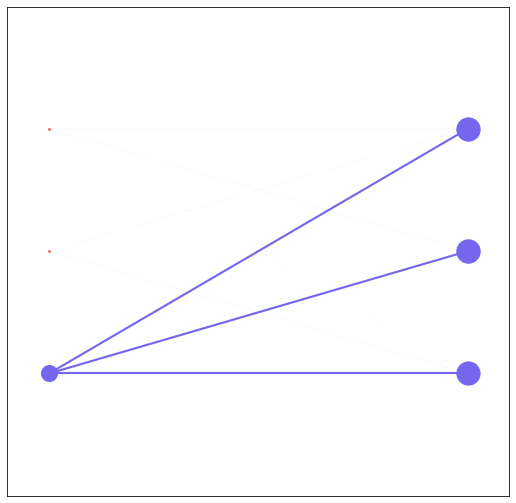

In [25]:
draw(W, nv, nh)